y norm max abs = 1.0
y norm mean abs = 0.0011740658653759282
y abs max = 19705.43137254902
mean values of y = 23.13547433701773
ULA iter    0, grad_norm=3.397e+06, sample_mean=1.232e-01, sample_std=1.736e-01
ULA iter   25, grad_norm=3.642e+05, sample_mean=4.574e+01, sample_std=7.027e+01
ULA iter   50, grad_norm=7.949e+04, sample_mean=4.901e+01, sample_std=7.947e+01
ULA iter   75, grad_norm=2.188e+04, sample_mean=4.925e+01, sample_std=8.139e+01
ULA iter  100, grad_norm=7.054e+03, sample_mean=4.926e+01, sample_std=8.188e+01
ULA iter  125, grad_norm=4.101e+03, sample_mean=4.926e+01, sample_std=8.202e+01
ULA iter  150, grad_norm=3.776e+03, sample_mean=4.926e+01, sample_std=8.205e+01
ULA iter  175, grad_norm=3.739e+03, sample_mean=4.926e+01, sample_std=8.206e+01
ULA iter  200, grad_norm=3.748e+03, sample_mean=4.926e+01, sample_std=8.207e+01
ULA iter  225, grad_norm=3.738e+03, sample_mean=4.926e+01, sample_std=8.207e+01
425.3030048347265
-78.85167887095423
abs_err: 3.3266757983254893e-13, re

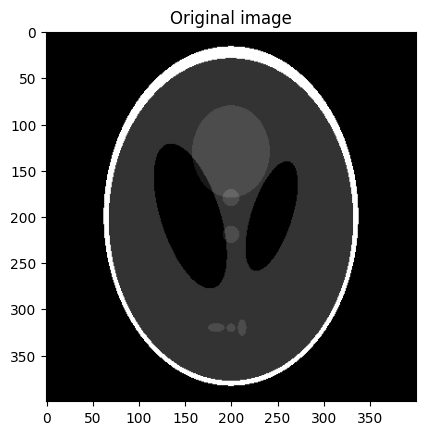

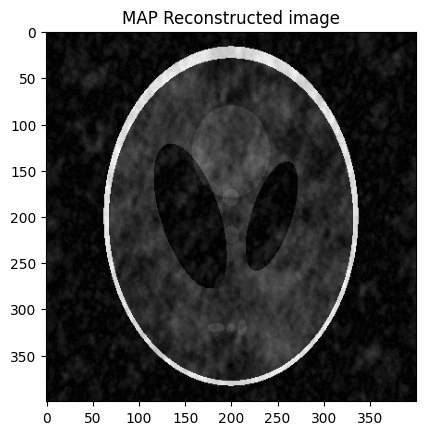

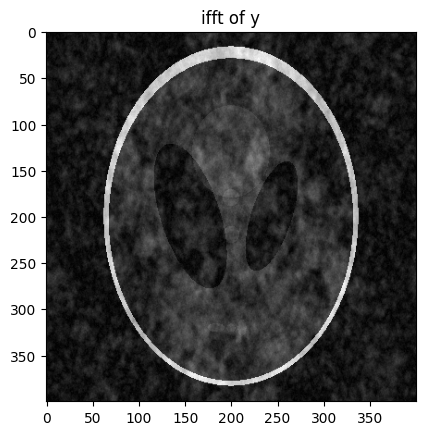

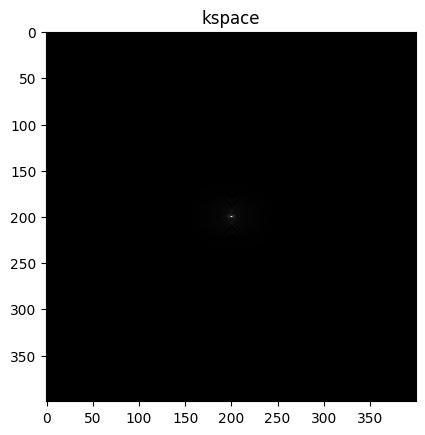

ULA iter    0, grad_norm=3.397e+06, sample_mean=1.232e-01, sample_std=1.736e-01
ULA iter   25, grad_norm=3.642e+05, sample_mean=4.574e+01, sample_std=7.027e+01
ULA iter   50, grad_norm=7.951e+04, sample_mean=4.901e+01, sample_std=7.946e+01
ULA iter   75, grad_norm=2.188e+04, sample_mean=4.925e+01, sample_std=8.139e+01
ULA iter  100, grad_norm=7.054e+03, sample_mean=4.926e+01, sample_std=8.188e+01
ULA iter  125, grad_norm=4.100e+03, sample_mean=4.926e+01, sample_std=8.202e+01
ULA iter  150, grad_norm=3.774e+03, sample_mean=4.926e+01, sample_std=8.205e+01
ULA iter  175, grad_norm=3.752e+03, sample_mean=4.926e+01, sample_std=8.206e+01
ULA iter  200, grad_norm=3.749e+03, sample_mean=4.926e+01, sample_std=8.207e+01
ULA iter  225, grad_norm=3.751e+03, sample_mean=4.926e+01, sample_std=8.207e+01
100


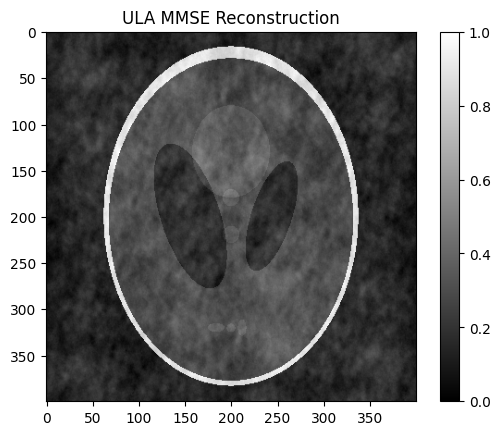

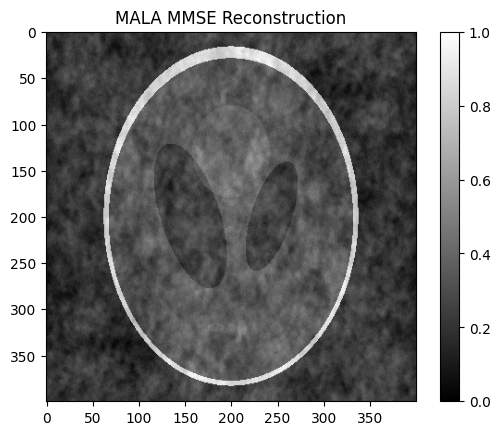

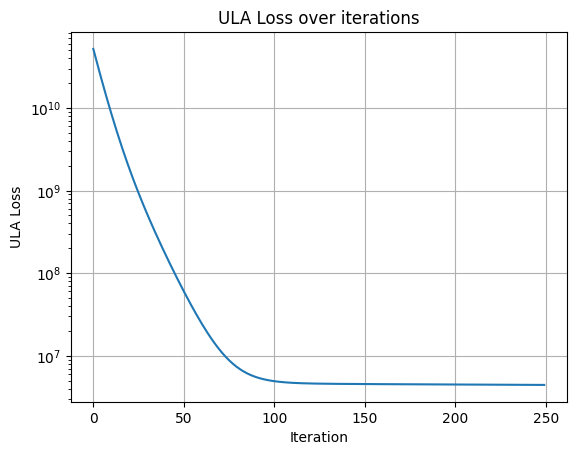

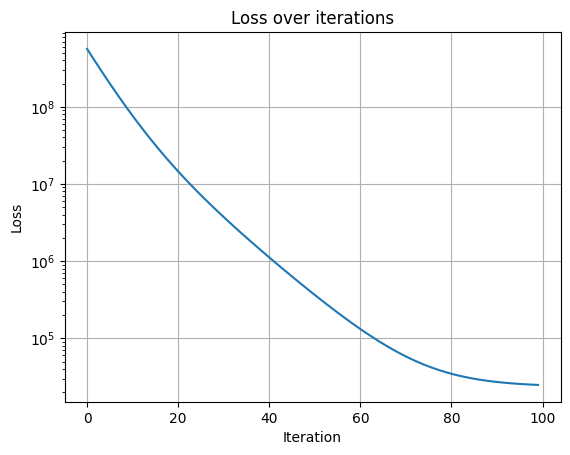

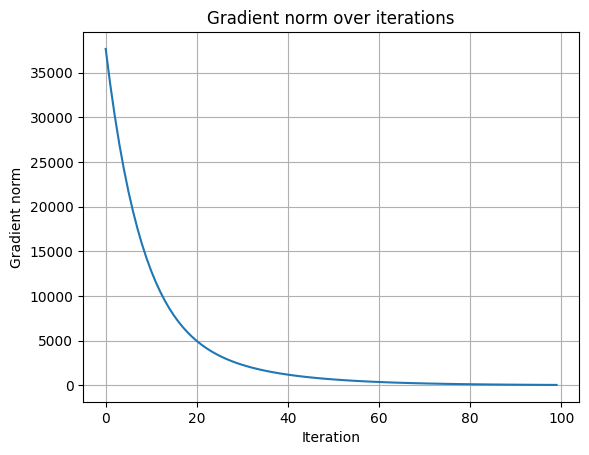

In [ ]:
import sys
import os

# Add the parent directory of MAP to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


import torch
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from utilities.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
)
from MAP.map_tv_minimize import MAPEstimator
from MMSE.mmse_ula import MMSEEstimatorULA
# from MMSE.metropolis_hastings import MHEstimator
from MMSE.mmse_mala import MMSEEstimatorMALA

# load iamge
shepp_logan = ski.data.shepp_logan_phantom()

# create mask (in the F domain)
column_mask = SimpleMask(2).mask_columns(shepp_logan)
row_mask = SimpleMask(3).mask_rows(shepp_logan) 
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask("gaussian", 2, seed=30).generate(shepp_logan.shape)
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, acceleration=8, seed=30).get_mask()

# the 'actual' measurement
y = centered_bernoulli_mask * np.fft.fft2(shepp_logan)

y_norm = y / np.max(y)
print(f"y norm max abs = {np.max(np.abs(y_norm))}")
print(f"y norm mean abs = {np.mean(np.abs(y_norm))}")
print(f"y abs max = {np.max(np.abs(y))}")
print(f"mean values of y = {np.mean(np.abs(y))}")


# x_init options
# x_init = np.fft.ifft2(bernoulli_mask * np.fft.fft2(shepp_logan)).real
#x_init = np.zeros_like(np.fft.ifft2(y).real)

# init the MAP and MMSE
map_estimator = MAPEstimator(centered_bernoulli_mask, 0.95, 0.01, 1e-2)
ula_estimator = MMSEEstimatorULA(centered_bernoulli_mask, 0.1, 2, 100e-2, 1e-3, 50, 2, 100)
# mh_estimator = MHEstimator(centered_bernoulli_mask, 0.1, 0.05, 100e-2, 0.01, 600, 3, 150)
mala_estimator = MMSEEstimatorMALA(centered_bernoulli_mask, 0.1, 2, 100e-2, 1e-1, 250, 2, 100 )

map_img_reconstruct = map_estimator.subgradient_descent(y)
samples, energies = ula_estimator.ula_sampling(y)
# mh_samples, acc_rate = mh_estimator.mh_sampling(y)
mala_samples = mala_estimator.mala_sampling(y)

print(np.max(samples))
print(np.min(samples))

abs_err, rel_err = map_estimator.adjoint_test(shepp_logan.shape)
print(f"abs_err: {abs_err}, rel_err: {rel_err}")
"""
kspace_shepp = np.fft.fft2(shepp_logan)
kspace_shepp_shifted = np.fft.fftshift(kspace_shepp) # shift to center the zero frequency for better visualization

reconstructed = np.real(np.fft.ifft2(kspace_shepp))
reconstructed_mag = np.real(np.fft.ifft2(np.abs(kspace_shepp) * np.exp(1j * 0)))
reconstructed_phase = np.real(np.fft.ifft2(np.exp(1j * np.angle(kspace_shepp))))

#masked_kspace_shepp = column_mask(kspace_shepp)
#masked_kspace_shepp_shifted = np.fft.fftshift(masked_kspace_shepp) # shift to center the zero frequency for better visualization

#masked_reconstructed = np.real(np.fft.ifft2(masked_kspace_shepp))
masked_reconstructed_mag = np.real(np.fft.ifft2(np.abs(kspace_shepp) * np.exp(1j * 0)))
masked_reconstructed_phase = np.real(np.fft.ifft2(np.exp(1j * np.angle(kspace_shepp))))
"""

# print(shepp_logan)
#print("------------------------")
# print("grad_y - min:", np.min(grad_y), "max:", np.max(grad_y))
# print("max value in x before fft2:", np.max(np.abs(shepp_logan)))

#plt.subplot(1, 4, 1)
plt.title("Original image")
plt.imshow(shepp_logan, cmap="gray")
plt.show()     
#plt.subplot(1, 4, 2)
plt.title("MAP Reconstructed image")
plt.imshow(np.abs(map_img_reconstruct), cmap="gray")
plt.show()     
#plt.subplot(1, 4, 3)
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(np.fft.ifftshift(y))), cmap="gray")
plt.show()     
#plt.subplot(1, 4, 4)
plt.title("kspace")
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(shepp_logan))), cmap='gray')
plt.show()

# plt.imshow(img_reconstruct - np.abs(np.fft.ifft2(y)))
# plt.imshow(img_reconstruct - x_init)
# plt.title("Difference image")
# plt.colorbar()

# mmse plot
plt.imshow(ula_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("ULA MMSE Reconstruction")
plt.colorbar()
plt.show()

#mala plot

plt.imshow(mala_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("MALA MMSE Reconstruction")
plt.colorbar()
plt.show()

# mh plot

# plt.imshow(mh_estimator.compute_mmse_estimate_hm(y), cmap="gray")
# plt.title("MH MMSE Reconstruction")
# plt.colorbar()
# plt.show()

# ula loss
plt.plot(energies)
plt.title("ULA Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("ULA Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

# loss
plt.plot(map_estimator.loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

# gradient
plt.plot(map_estimator.grad_norm_history)
plt.title("Gradient norm over iterations")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid(True)
#plt.yscale('log')
plt.show()

# # testing if tv works
# g_tv_true = map_estimator.huber_tv_subgradient(shepp_logan)
# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1); plt.imshow(shepp_logan, cmap='gray'); plt.title('true image'); plt.axis('off')
# plt.subplot(1,2,2); plt.imshow(g_tv_true, cmap='RdBu'); plt.title('g_tv on true'); plt.colorbar(); plt.axis('off')
